In [1]:
library(tidyverse)
library(MASS)
library(glmnet)
library(rlist)
library(superheat)

source('./simulation_utils.R')

options(repr.plot.width=6, repr.plot.height=4) # plot sizes in this notebook


Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-13

Loading required package: caret
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:
set.seed(5645654)

In [3]:
save_figs <- FALSE

# Load the fixed parameters 

In [4]:
load('./simulation_results/fixed_params/lasso_fixed_params.RData')

In [5]:
ls()

[1] "beta_full"             "choose_joint_lambda_k" "choose_lambda_cv"     
 [4] "choose_lambda_ic"      "compute_sigma2_hat"    "covar_x"              
 [7] "d"                     "draw_cs_vs_sample"     "draw_linear_responses"
[10] "get_copas_k"           "get_mspe"              "get_slope"            
[13] "get_two_step_cv_k"     "mu_x"                  "n_cs"                 
[16] "n_vs"                  "outfile"               "save_figs"            
[19] "x_cs"                  "x_cs_"

In [6]:
# superheat(x_cs)

In [7]:
# results directory
results_dir <- './simulation_results/lasso_sigma_simulations/'

In [8]:
file_list <- list.files(path = results_dir, pattern = '*.rds')

In [9]:
file_list

[1] "lasso_sim_results_sigma10_sparsity950.rds"
 [2] "lasso_sim_results_sigma11_sparsity950.rds"
 [3] "lasso_sim_results_sigma12_sparsity950.rds"
 [4] "lasso_sim_results_sigma13_sparsity950.rds"
 [5] "lasso_sim_results_sigma14_sparsity950.rds"
 [6] "lasso_sim_results_sigma15_sparsity950.rds"
 [7] "lasso_sim_results_sigma1_sparsity950.rds" 
 [8] "lasso_sim_results_sigma2_sparsity950.rds" 
 [9] "lasso_sim_results_sigma3_sparsity950.rds" 
[10] "lasso_sim_results_sigma4_sparsity950.rds" 
[11] "lasso_sim_results_sigma5_sparsity950.rds" 
[12] "lasso_sim_results_sigma6_sparsity950.rds" 
[13] "lasso_sim_results_sigma7_sparsity950.rds" 
[14] "lasso_sim_results_sigma8_sparsity950.rds" 
[15] "lasso_sim_results_sigma9_sparsity950.rds"

In [10]:
get_results_across_sigma <- function(results_dir, name){
    file_list <- list.files(path = results_dir, pattern = '*.rds')
    
    result_vec <- c()
    sigmas <- c()
    for(i in 1:length(file_list)){
        result_list <- list.load(paste0(results_dir, file_list[i]))
        
        result_vec <- c(result_vec, result_list[[name]])
        sigmas <- c(sigmas, rep(result_list$sigma, length(result_list[[name]])))
        
    }
    return(list(results = result_vec, 
               sigmas = sigmas))
}

# Load slope results

In [11]:
slopes <- c()
sigmas <- c()
method <- c()

lambda_only_slopes <- get_results_across_sigma(results_dir, 'lambda_only_slope_vs')
slopes <- c(slopes, lambda_only_slopes$results)
sigmas <- c(sigmas, lambda_only_slopes$sigmas)
method <- c(method, rep('lasso', length(lambda_only_slopes$sigmas)))

joint_slopes <- get_results_across_sigma(results_dir, 'joint_slope_vs')
slopes <- c(slopes, joint_slopes$results)
sigmas <- c(sigmas, joint_slopes$sigmas)
method <- c(method, rep('joint', length(lambda_only_slopes$sigmas)))

copas_result_dir <- './simulation_results/copas_lasso_results/varying_sigma/'
copas_slopes <- get_results_across_sigma(copas_result_dir, 'copas_slope_vs')
slopes <- c(slopes, copas_slopes$results)
sigmas <- c(sigmas, copas_slopes$sigmas)
method <- c(method, rep('Copas', length(copas_slopes$sigmas)))

two_step_dir <- './simulation_results/two_step_lasso_results/varying_sigma/'
two_step_slopes <- get_results_across_sigma(two_step_dir, 'two_step_slope_vs')
slopes <- c(slopes, two_step_slopes$results)
sigmas <- c(sigmas, two_step_slopes$sigmas)
method <- c(method, rep('two_step', length(two_step_slopes$sigmas)))

slopes_df <- data.frame(slopes = slopes, 
                       sigma = sigmas, 
                       method = method)

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

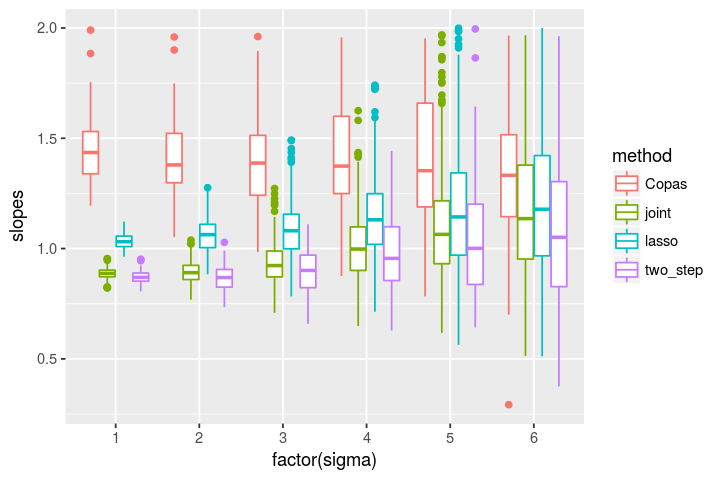

In [12]:
slopes_df %>% 
    filter(sigma < 7, slopes < 2) %>%
    ggplot() + 
        geom_boxplot(aes(x = factor(sigma), y = slopes, colour = method), position=position_dodge(width=0.8))

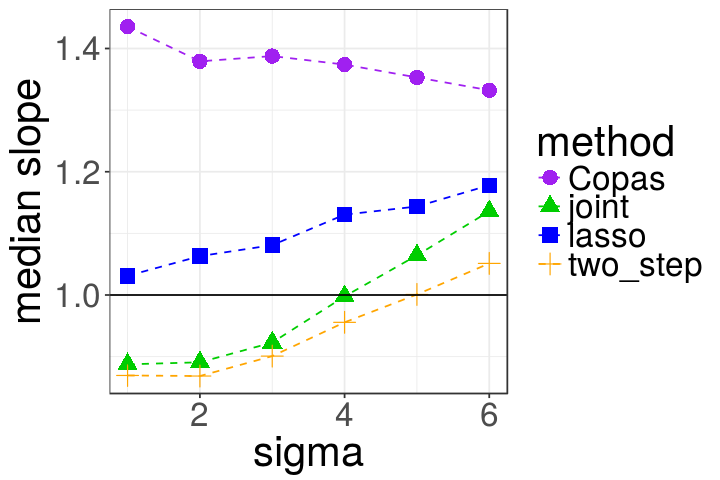

In [13]:
slopes_df %>% 
    filter(sigma < 7, slopes < 2) %>%
    group_by(sigma, method) %>% 
    summarize(median_slope = median(slopes)) %>%
    ggplot(aes(x = sigma, y = median_slope)) + 
        geom_point(aes(color = method, shape = method), size = 4) + 
        geom_line(aes(color = method), linetype = 'dashed')  + 
        scale_color_manual(values = c('purple', 'green3', 'blue', 'orange')) + 
        geom_hline(yintercept = 1.0) + 
        ylab('median slope') + theme_bw() + 
        theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))

if(save_figs){
    ggsave('../writing/lasso_figures/slope_vs_sigma.png', height = 6, width = 9)
}

In [14]:
# Lets look at one particular sigma

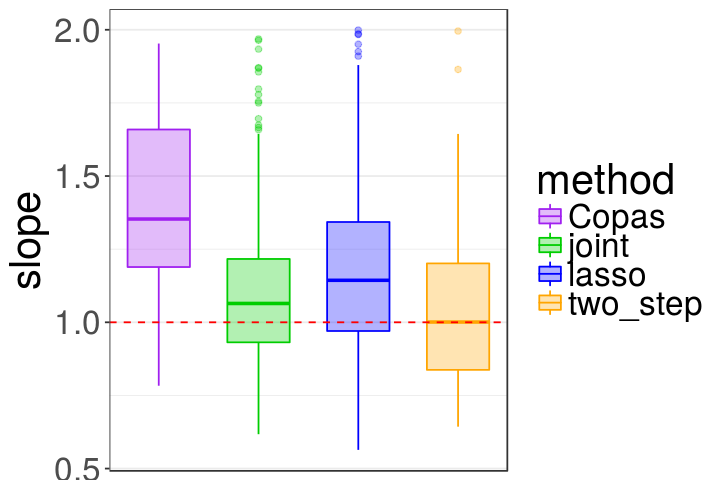

In [15]:
slopes_df %>% 
    filter(sigma == 5, slopes < 2) %>%
    ggplot() + 
        geom_boxplot(aes(x = sigma, y = slopes, colour = method, fill = method), alpha = 0.3, 
                     position=position_dodge(width=0.8), width = 0.5) + 
        scale_color_manual(values = c('purple', 'green3', 'blue', 'orange')) + 
        scale_fill_manual(values = c('purple', 'green3', 'blue', 'orange')) + 
        geom_hline(yintercept = 1.0, color = 'red', linetype = 'dashed') + 
        ylab('slope') + 
        theme_bw() + 
        theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5)) + 
        theme(axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank()) + scale_x_continuous(breaks = NULL)

if(save_figs){
    ggsave('../writing/lasso_figures/slopes_sigma5.png', height = 6, width = 9)    
}


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


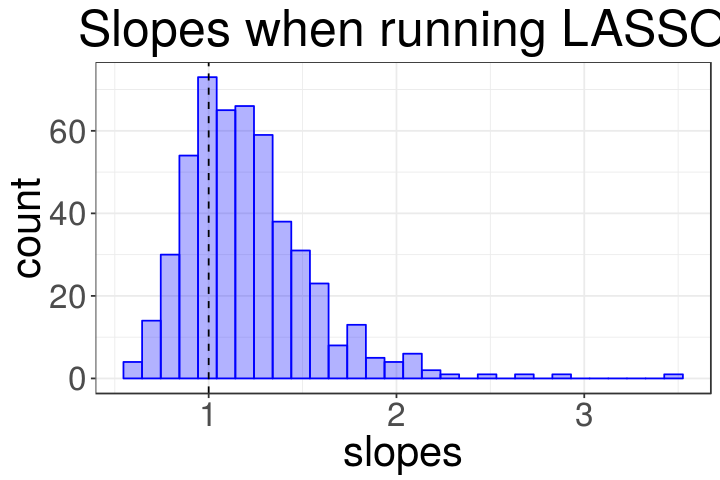

In [46]:
slopes_df %>% 
    filter(sigma == 5, method == 'lasso') %>%
    ggplot() + 
        geom_histogram(aes(x = slopes), colour = 'blue', fill = 'blue', alpha = 0.3) + 
        ggtitle('Slopes when running LASSO') + 
        geom_vline(xintercept = 1.0, linetype = 'dashed') + 
        theme_bw() + 
        theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5)) 

if(TRUE){
    ggsave('../writing/lasso_figures/hist_lasso_sigma5.png', height = 6, width = 9)    
}


In [16]:
# Look at MSPEs

In [17]:
mspes <- c()
sigmas <- c()
method <- c()

lambda_only_mspes <- get_results_across_sigma(results_dir, 'lambda_only_mspe_vs')
mspes <- c(mspes, lambda_only_mspes$results)
sigmas <- c(sigmas, lambda_only_mspes$sigmas)
method <- c(method, rep('lasso', length(lambda_only_mspes$sigmas)))

joint_mspes <- get_results_across_sigma(results_dir, 'joint_mspe_vs')
mspes <- c(mspes, joint_mspes$results)
sigmas <- c(sigmas, joint_mspes$sigmas)
method <- c(method, rep('joint', length(lambda_only_mspes$sigmas)))

copas_result_dir <- './simulation_results/copas_lasso_results/varying_sigma/'
copas_mspes <- get_results_across_sigma(copas_result_dir, 'copas_mspe_vs')
mspes <- c(mspes, copas_mspes$results)
sigmas <- c(sigmas, copas_mspes$sigmas)
method <- c(method, rep('Copas', length(copas_mspes$sigmas)))

two_step_dir <- './simulation_results/two_step_lasso_results/varying_sigma/'
two_step_mspes <- get_results_across_sigma(two_step_dir, 'two_step_mspe_vs')
mspes <- c(mspes, two_step_mspes$results)
sigmas <- c(sigmas, two_step_mspes$sigmas)
method <- c(method, rep('two_step', length(two_step_mspes$sigmas)))

mspes_df <- data.frame(mspe = mspes, 
                       sigma = sigmas, 
                       method = method)

In [18]:
unique(mspes_df$method)

[1] lasso    joint    Copas    two_step
Levels: Copas joint lasso two_step

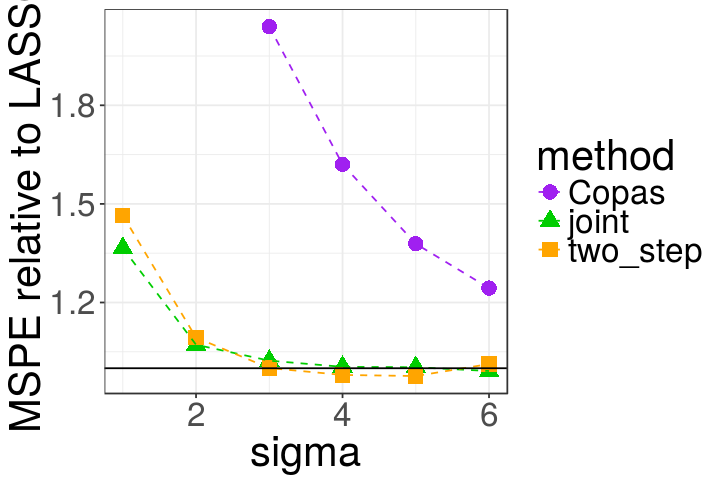

In [19]:
mspes_df %>% 
    filter(sigma < 7) %>% 
    group_by(sigma, method) %>% 
    summarize(median_mspe = median(mspe, na.rm = TRUE)) %>% 
    spread(method, median_mspe) %>% 
    mutate(Copas = Copas / lasso, joint = joint / lasso, two_step = two_step / lasso) %>% 
    gather(key = 'method', value = 'median_mspe', joint, lasso, two_step, Copas) %>% 
    filter(method != 'lasso')  %>% 
    filter(median_mspe < 2.5) %>%
    ggplot(aes(x = sigma, y = median_mspe)) + 
        geom_point(aes(color = method, shape = method), size = 4) + 
        geom_line(aes(color = method), linetype = 'dashed')  + 
        scale_color_manual(values = c('purple', 'green3', 'orange')) + 
        geom_hline(yintercept = 1.0) + 
        ylab('MSPE relative to LASSO') + theme_bw() + 
        theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))

ggsave('../writing/lasso_figures/mspe_vs_sigma.png', height = 6, width = 9)    

In [20]:
head(mspes_df)

mspe,sigma,method
149.8927,10,lasso
103.1686,10,lasso
142.3887,10,lasso
119.1121,10,lasso
125.3563,10,lasso
115.5612,10,lasso


Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

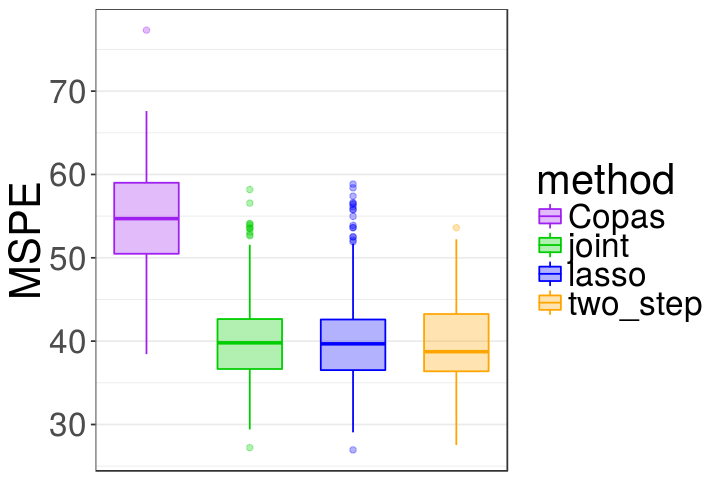

In [21]:
mspes_df %>% 
    filter(sigma == 5) %>%
    ggplot() + 
        geom_boxplot(aes(x = sigma, y = mspe, colour = method, fill = method), alpha = 0.3, 
                          position=position_dodge(width=0.8), width = 0.5) + 
        scale_color_manual(values = c('purple', 'green3', 'blue', 'orange')) + 
        scale_fill_manual(values = c('purple', 'green3', 'blue', 'orange')) + 
        ylab('MSPE') + 
        theme_bw() + 
        theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5)) + 
        theme(axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank()) + scale_x_continuous(breaks = NULL)

if(save_figs){
    ggsave('../writing/lasso_figures/mspes_sigma5.png', height = 6, width = 9)    
}
